In [1]:
!hostname

n115.clstr


In [1]:
import pandas as pd 
import requests
import io
import numpy as np
import matplotlib.pyplot as plt
import glob
import xarray as xr
import geopandas as gpd
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
winter_months = [11, 12, 1, 2, 3]

Alaska Shapefiles 
-

In [30]:
shapefile_path = "/center1/DYNDOWN/phutton5/ROS/boundaries/Alaska_Borough_and_Census_Area_Boundaries.shp"
borough_boundaries = gpd.read_file(shapefile_path)
borough_boundaries = borough_boundaries.set_crs(epsg=3338)
borough_boundaries = borough_boundaries.to_crs(epsg=4326)
FNSB_boundary = borough_boundaries[borough_boundaries['CommunityN'] == 'Fairbanks North Star Borough']
FNSB_geom = FNSB_boundary.geometry.iloc[0] 
FNSB_coords = []
FNSB_coords.extend(list(FNSB_geom.exterior.coords))
FNSB_coords = np.array(FNSB_coords)  
FNSB_coords = pd.DataFrame({
    "lon": FNSB_coords[:, 0],
    "lat": FNSB_coords[:, 1]})

Fairbanks_lat=(64.84)
Fairbanks_lon=(-147.72)

ASOS 
-

In [4]:
website='https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?network=AK_ASOS&station=PABE&data=tmpc&data=p01m&data=wxcodes&data=snowdepth&year1=1949&month1=11&day1=1&year2=2023&month2=3&day2=31&tz=America%2FAnchorage&format=onlycomma&latlon=yes&elev=no&missing=M&trace=0.0001&direct=no&report_type=3&report_type=4'
#https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?network=AK_ASOS&station=PAFA&data=tmpc&data=p01m&data=wxcodes&data=snowdepth&year1=1950&month1=1&day1=1&year2=2023&month2=12&day2=9&tz=America%2FAnchorage&format=onlycomma&latlon=yes&elev=no&missing=M&trace=T&direct=no&report_type=3&report_type=4'
response = requests.get(website)
if response.status_code == 200:
    data = io.StringIO(response.text)
    df = pd.read_csv(data, comment="#")  
    print(df.head())
else:
    print("Error:", response.status_code)

  station             valid       lon      lat   tmpc p01m wxcodes snowdepth
0    PABE  1949-11-01 00:00 -161.8264  60.7858  -2.78    M       M         M
1    PABE  1949-11-01 01:00 -161.8264  60.7858  -2.78    M       M         M
2    PABE  1949-11-01 02:00 -161.8264  60.7858  -2.22    M       M         M
3    PABE  1949-11-01 03:00 -161.8264  60.7858  -2.22    M       M         M
4    PABE  1949-11-01 04:00 -161.8264  60.7858  -2.22    M       M         M


In [33]:
df['valid'] = pd.to_datetime(df['valid'])
df['month'] = df['valid'].dt.month
df['date'] = df['valid'].dt.date
df['time'] = df['valid'].dt.time
#df['tmpc']
#df = df.drop(columns=['column_name'])
winter_df = df[df['month'].isin([11, 12, 1, 2, 3])] #filter to only keep the ROS months 

winter_df['date'] = pd.to_datetime(winter_df['date'])
year = winter_df['date'].dt.year
month = winter_df['date'].dt.month
season_start = year.where(~month.isin([1, 2, 3]), year - 1)
season_end = season_start + 1
winter_df['season'] = season_start.astype(str) + '-' + season_end.astype(str)

#filter to only when RA is present 
mask = winter_df['wxcodes'].str.contains('RA', na=False)
rain_and_mixed_df = winter_df[mask]
rain_and_mixed_df['p01m'] = rain_and_mixed_df['p01m'].replace('M', np.nan) 
rain_and_mixed_df['p01m'] = rain_and_mixed_df['p01m'].replace('T', np.nan) 
rain_and_mixed_df['p01m'] = pd.to_numeric(rain_and_mixed_df['p01m'], errors='coerce')

/center1/DYNDOWN/phutton5/VSCODE_dump/ipykernel_2360025/854007281.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winter_df['date'] = pd.to_datetime(winter_df['date'])
/center1/DYNDOWN/phutton5/VSCODE_dump/ipykernel_2360025/854007281.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winter_df['season'] = season_start.astype(str) + '-' + season_end.astype(str)
/center1/DYNDOWN/phutton5/VSCODE_dump/ipykernel_2360025/854007281.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [38]:
seasonal_sum_rain_and_mixed_df = (rain_and_mixed_df.groupby('season')['p01m'].sum())
monthly_sum_ASOS = (rain_and_mixed_df.groupby(['month'])['p01m'].sum())
monthly_sum_ASOS=monthly_sum_ASOS.reindex(winter_months).values 

monthly_mean_by_season_ASOS = (rain_and_mixed_df.groupby(['season', 'month'])['p01m'].mean().unstack('month'))

start_years = seasonal_sum_rain_and_mixed_df.index.str.slice(0, 4).astype(int)
all_seasons = [f"{y}-{y+1}" for y in range(start_years.min(), start_years.max() + 1)]

seasonal_sum_rain_and_mixed_df = seasonal_sum_rain_and_mixed_df.reindex(all_seasons)
#seasonal_sum_rain_and_mixed_df=seasonal_sum_rain_and_mixed_df.fillna(0)
seasons_seasonal_sum_rain_and_mixed_df = seasonal_sum_rain_and_mixed_df.index.tolist()




#Rain only, no other precip, not realistic max of 2mm 
'''
mask = winter_df['wxcodes'].str.fullmatch(r'[-+]?(SH)?RA') #matches 'RA' or '-RA' and SH RA
rain_only_df = winter_df[mask]
rain_only_df['p01m'] = rain_only_df['p01m'].replace(['M', 'T'], np.nan)
rain_only_df['p01m'] = pd.to_numeric(rain_only_df['p01m'], errors='coerce') # Convert to numeric (float)

seasonal_sum_rain_only_df = (rain_only_df.loc[rain_only_df['p01m'] >= 0.254].groupby('season')['p01m'].sum())
#seasonal_sum_rain_only_df=rain_only_df.groupby('season')['p01m'].sum()
seasonal_sum_rain_only_df = seasonal_sum_rain_only_df.reindex(all_seasons)
seasonal_sum_rain_only_df=seasonal_sum_rain_only_df.fillna(0)
seasons_seasonal_sum_rain_df = seasonal_sum_rain_only_df.index.tolist()
'''

"\nmask = winter_df['wxcodes'].str.fullmatch(r'[-+]?(SH)?RA') #matches 'RA' or '-RA' and SH RA\nrain_only_df = winter_df[mask]\nrain_only_df['p01m'] = rain_only_df['p01m'].replace(['M', 'T'], np.nan)\nrain_only_df['p01m'] = pd.to_numeric(rain_only_df['p01m'], errors='coerce') # Convert to numeric (float)\n\nseasonal_sum_rain_only_df = (rain_only_df.loc[rain_only_df['p01m'] >= 0.254].groupby('season')['p01m'].sum())\n#seasonal_sum_rain_only_df=rain_only_df.groupby('season')['p01m'].sum()\nseasonal_sum_rain_only_df = seasonal_sum_rain_only_df.reindex(all_seasons)\nseasonal_sum_rain_only_df=seasonal_sum_rain_only_df.fillna(0)\nseasons_seasonal_sum_rain_df = seasonal_sum_rain_only_df.index.tolist()\n"

array([592.0384, 221.7645, 116.0567, 135.3057, 139.8848])

In [8]:
seasonal_sum_rain_and_mixed_df.replace(0, np.nan, inplace=True)
seasonal_sum_rain_and_mixed_df

season
1949-1950        NaN
1950-1951        NaN
1951-1952        NaN
1952-1953        NaN
1953-1954        NaN
              ...   
2018-2019    53.9571
2019-2020    82.1683
2020-2021    36.9660
2021-2022    89.5473
2022-2023    63.1295
Name: p01m, Length: 74, dtype: float64

Plotting
-

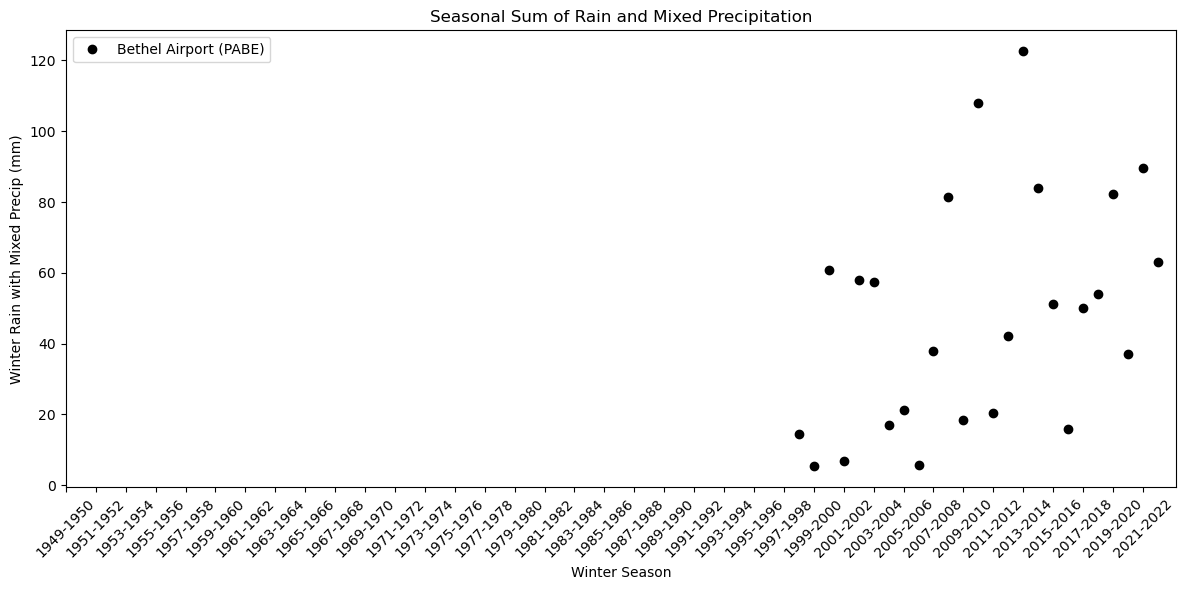

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(seasons_seasonal_sum_rain_and_mixed_df,seasonal_sum_rain_and_mixed_df, marker='o', linestyle='', color='black',label='Bethel Airport (PABE)')
plt.gca().patch.set_alpha(0.0)
plt.title('Seasonal Sum of Rain and Mixed Precipitation')
plt.xlabel('Winter Season')
plt.ylabel('Winter Rain with Mixed Precip (mm)')
plt.xticks(ticks=range(0, len(seasons_seasonal_sum_rain_and_mixed_df), 2), labels=seasons_seasonal_sum_rain_and_mixed_df[::2], rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

To Compare PAFA, DYN and RAW
-


In [11]:
pabe_lat=60.7858
pabe_lon=-161.8264

#selected values later are 61.183758 -149.99158

In [12]:
def getXY(lat, lon, dataarray):
    abslat = np.abs(dataarray.XLAT-lat)
    abslon = np.abs(dataarray.XLONG-lon)
    d = abslon**2 + abslat**2
    flat_index = np.argmin(d.values)
    yloc, xloc = np.unravel_index(flat_index, d.shape)
    return xloc, yloc

def getXY_latlon(lat, lon, dataarray):
    abslat = np.abs(dataarray.latitude - lat)
    abslon = np.abs(dataarray.longitude - lon)
    d = abslon**2 + abslat**2
    flat_index = np.argmin(d.values)
    yloc, xloc = np.unravel_index(flat_index, d.shape)
    return xloc, yloc

In [9]:
regridded_era5_path='/center1/DYNDOWN/phutton5/ROS/All_of_AK/All_of_AK_netcdf_files/ERA5_31kmto4km_nearest_regridded.nc'
regridded_era5=xr.open_dataset(regridded_era5_path)

#ERA5  4km
era5_4km='/center1/DYNDOWN/phutton5/ROS/All_of_AK/All_of_AK_netcdf_files/ROS_Monthly_*.nc'
era5_4km = xr.open_mfdataset(era5_4km,combine="by_coords", parallel=True)


In [13]:
x_idx, y_idx = getXY(pabe_lat, pabe_lon, regridded_era5)
nearest_lat = regridded_era5.XLAT[y_idx, x_idx]
nearest_lon = regridded_era5.XLONG[y_idx, x_idx]


In [14]:
cell = era5_4km.isel(
    south_north=y_idx,
    west_east=x_idx
)

In [15]:
era5_4km_rain_sum_at_site = era5_4km['rain_ros_sum'].isel(south_north=x_idx,west_east=y_idx)
seasonal_rain_sum_at_site_era5_4km=era5_4km_rain_sum_at_site.sum(dim='month')
monthly_rain_sum_at_site_era5_4km=era5_4km_rain_sum_at_site.sum(dim='season')

era5_regridded_31km_rain_sum_at_site = regridded_era5['rain_ros_sum'].isel(south_north=x_idx,west_east=y_idx)
seasonal_rain_sum_at_site_era5_regridded_31km=era5_regridded_31km_rain_sum_at_site.sum(dim='month')
monthly_rain_sum_at_site_era5_regridded_31km=era5_regridded_31km_rain_sum_at_site.sum(dim='season')

seasons=era5_4km['season']

IndexError: index 11 is out of bounds for axis 0 with size 5

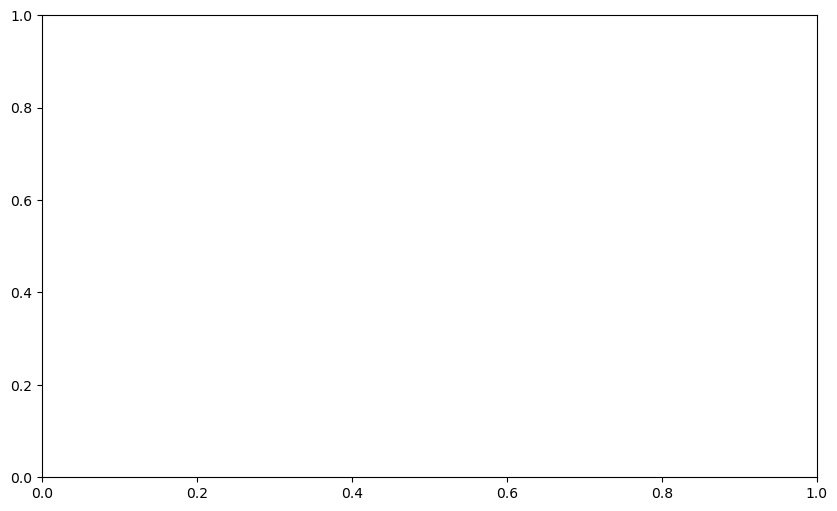

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

spacing = 4
width = 0.6

colors = ['green', 'blue', 'black']
labels = ['ERA5 4km', 'ERA5 31km', 'Station Data PAFA']

positions_all = []
data_all = []

for i, month in enumerate(winter_months):
    month_4km = era5_4km_rain_sum_at_site.sel(month=month).values
    month_31km = era5_regridded_31km_rain_sum_at_site.sel(month=month).values
    month_station = monthly_sum_ASOS[month].dropna().values

    month_data = [month_4km, month_31km, month_station]

    pos = [i * spacing + j for j in range(3)]
    positions_all.extend(pos)
    data_all.extend(month_data)

bp = ax.boxplot(
    data_all,
    positions=positions_all,
    widths=0.6,
    patch_artist=True,
    showfliers=True
)

# Color boxes
for i, patch in enumerate(bp['boxes']):
    patch.set_facecolor(colors[i % 3])

# X-axis formatting
ax.set_xticks([i * spacing + 1 for i in range(len(winter_months))])
ax.set_xticklabels(month_labels)

ax.set_ylabel('Precipitation (mm)')
ax.set_title('Winter Monthly Precipitation Distribution')

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', label='ERA5 4km'),
    Patch(facecolor='blue', label='ERA5 31km'),
    Patch(facecolor='black', label='Station Data PAFA')
]
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()


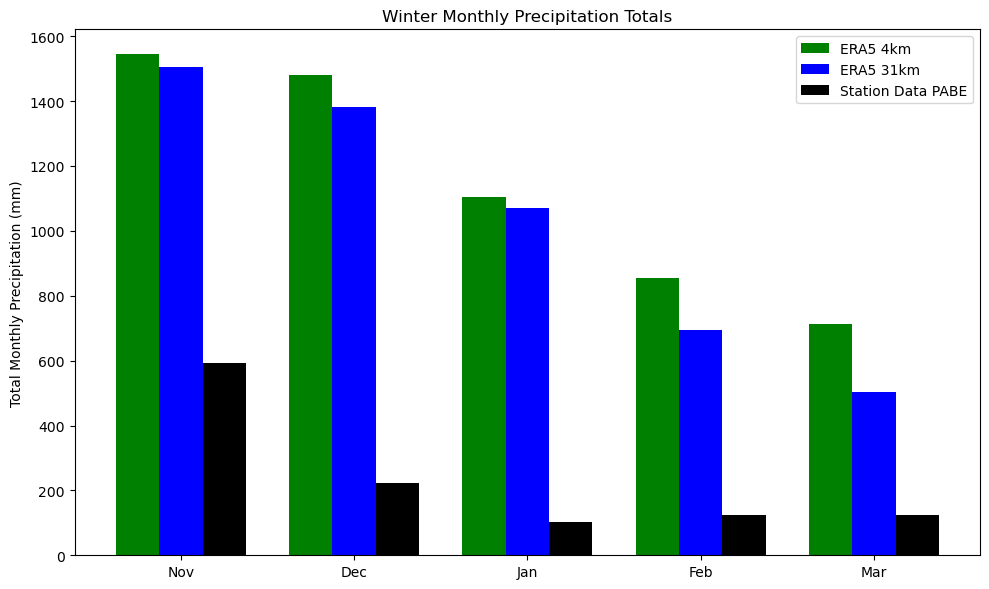

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

winter_months = [11, 12, 1, 2, 3]
month_labels = ['Nov','Dec','Jan','Feb','Mar']

sum_4km = []
sum_31km = []
sum_station = []

for month in winter_months:
    sum_4km.append(
        np.nansum(monthly_rain_sum_at_site_era5_4km.sel(month=month).values)
    )
    sum_31km.append(
        np.nansum(monthly_rain_sum_at_site_era5_regridded_31km.sel(month=month).values)
    )
    sum_station.append(
        np.nansum(monthly_sum_ASOS[month].values)
    )

x = np.arange(len(winter_months))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - width, sum_4km, width, color='green', label='ERA5 4km')
ax.bar(x,         sum_31km, width, color='blue',  label='ERA5 31km')
ax.bar(x + width, sum_station, width, color='black', label='Station Data PABE')

ax.set_xticks(x)
ax.set_xticklabels(month_labels)
ax.set_ylabel('Total Monthly Precipitation (mm)')
ax.set_title('Winter Monthly Precipitation Totals')
ax.legend()

plt.tight_layout()
plt.show()


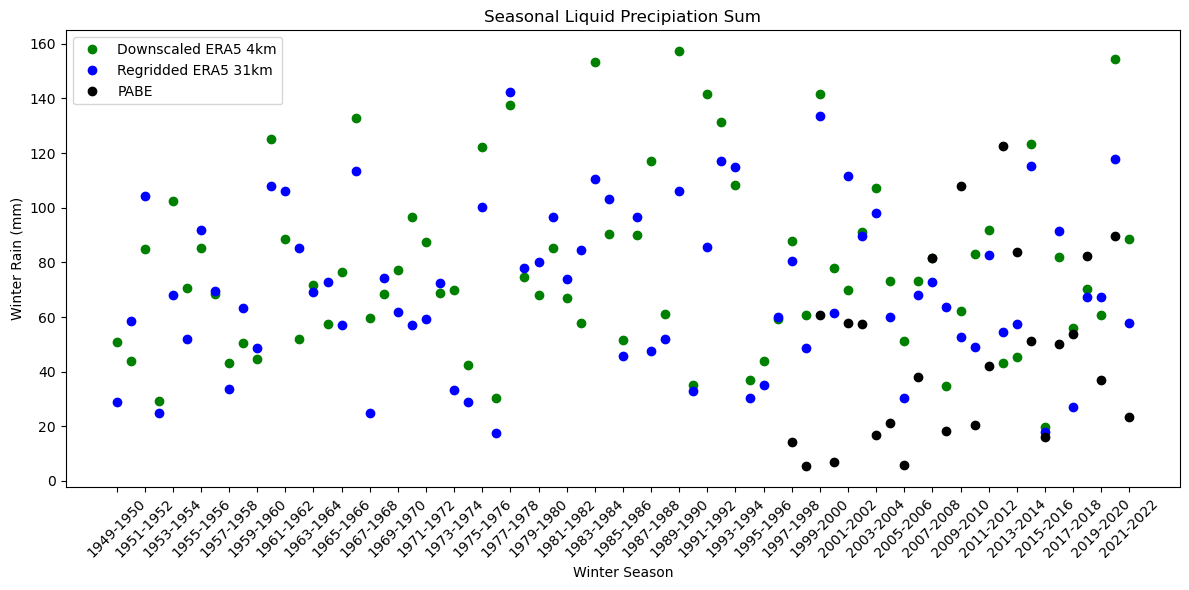

In [76]:
plt.figure(figsize=(12, 6))
plt.plot(seasons,seasonal_rain_sum_at_site_era5_4km, marker='o',label='Downscaled ERA5 4km', linestyle='', color='green')
plt.plot(seasons,seasonal_rain_sum_at_site_era5_regridded_31km, marker='o', label='Regridded ERA5 31km', linestyle='', color='blue')
plt.plot(seasons_seasonal_sum_rain_and_mixed_df,seasonal_sum_rain_and_mixed_df, label='PABE',marker='o', linestyle='', color='black')
plt.gca().patch.set_alpha(0.0)
plt.title('Seasonal Liquid Precipiation Sum')
plt.xlabel('Winter Season')
plt.ylabel('Winter Rain (mm)')
plt.xticks(ticks=range(0, len(seasons_seasonal_sum_rain_and_mixed_df), 2),labels=seasons_seasonal_sum_rain_and_mixed_df[::2],rotation=45) 
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
monthly_rain_sum_at_site_era5_4km
monthly_rain_sum_at_site_era5_regridded_31km
monthly_sum_by_season_ASOS

month,1,2,3,11,12
season,,,,,
1949-1950,0.0000,NaN,0.0000,0.0000,0.0000
1950-1951,NaN,0.0000,NaN,0.0000,0.0000
1951-1952,0.0000,0.0000,0.0000,0.0000,0.0000
1952-1953,0.0000,0.0000,NaN,0.0000,NaN
1953-1954,0.0000,NaN,0.0000,0.0000,NaN
...,...,...,...,...,...
2018-2019,4.0433,24.3534,9.3342,15.7248,0.5014
2019-2020,0.5002,0.0001,10.6533,68.4841,2.5306
2020-2021,7.5906,1.0011,0.0000,27.3640,1.0103


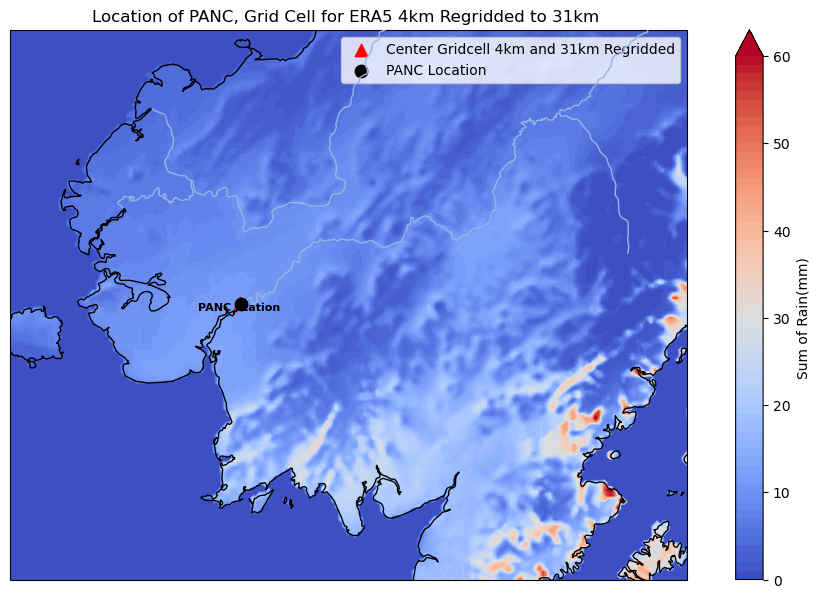

In [77]:
AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea( central_longitude=-154, central_latitude=50, standard_parallels=(55, 65))}
fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10,6))
cf = ax.contourf(era5_4km['XLONG'], era5_4km['XLAT'], np.mean(era5_4km['ros_tally'],axis=(0,1)) , cmap='coolwarm',levels=np.arange(0,61,1), extend='max',transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='Sum of Rain(mm)', ticks=np.arange(0,70,10))
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

#FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
#ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=10, s=80,label='Fairbanks', transform=ccrs.PlateCarree())
#ax.text(Fairbanks_lon, Fairbanks_lat + 0.1, 'Fairbanks',
#        transform=ccrs.PlateCarree(), ha='center', va='bottom',
#        fontsize=8, zorder=10, fontweight='bold', color='black')

ax.scatter(cell.XLONG.values, cell.XLAT.values,marker='^',s=80,color='red',zorder=10,label='Center Gridcell 4km and 31km Regridded',transform=ccrs.PlateCarree()  )

ax.scatter(pabe_lon, pabe_lat, marker='o', color='black', zorder=10, s=80,label='PANC Location', transform=ccrs.PlateCarree())
ax.text(pabe_lon, pabe_lat - 0.1, 'PANC Station',
        transform=ccrs.PlateCarree(), ha='center', va='bottom',
        fontsize=8, zorder=10, fontweight='bold', color='black')

ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)

ax.set_extent([-166.0, -152.0, 58.0, 63.5], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_title("Location of PANC, Grid Cell for ERA5 4km Regridded to 31km ")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

fig.patch.set_alpha(0.0)
plt.legend()
plt.tight_layout()
plt.show() 

FILTERING 
-

In [18]:
era5_4km_rain_sum_at_site

<xarray.DataArray 'rain_ros_sum' (season: 73, month: 5)> Size: 1kB
dask.array<getitem, shape=(73, 5), dtype=float32, chunksize=(1, 5), chunktype=numpy.ndarray>
Coordinates:
  * season      (season) <U9 3kB '1950-1951' '1951-1952' ... '2022-2023'
  * month       (month) int64 40B 11 12 1 2 3
    XLAT        float32 4B dask.array<chunksize=(), meta=np.ndarray>
    XLONG       float32 4B dask.array<chunksize=(), meta=np.ndarray>
    month_name  (month) <U3 60B dask.array<chunksize=(5,), meta=np.ndarray>

In [19]:
start_year = '1997-1998'
era5_4km_rain_sum_at_site_filtered = era5_4km_rain_sum_at_site.sel(season=era5_4km_rain_sum_at_site.season >= start_year)
filtered_seasonal_rain_sum_at_site_era5_4km=era5_4km_rain_sum_at_site_filtered.sum(dim='season')

era5_regridded_31km_rain_sum_at_site_filtered = era5_regridded_31km_rain_sum_at_site.sel(season=era5_regridded_31km_rain_sum_at_site.season >= start_year)
filtered_seasonal_rain_sum_at_site_era5_regridded_31km=era5_regridded_31km_rain_sum_at_site_filtered.sum(dim='season')

In [41]:
monthly_sum_ASOS

array([592.0384, 221.7645, 116.0567, 135.3057, 139.8848])

IndexError: index 11 is out of bounds for axis 0 with size 5

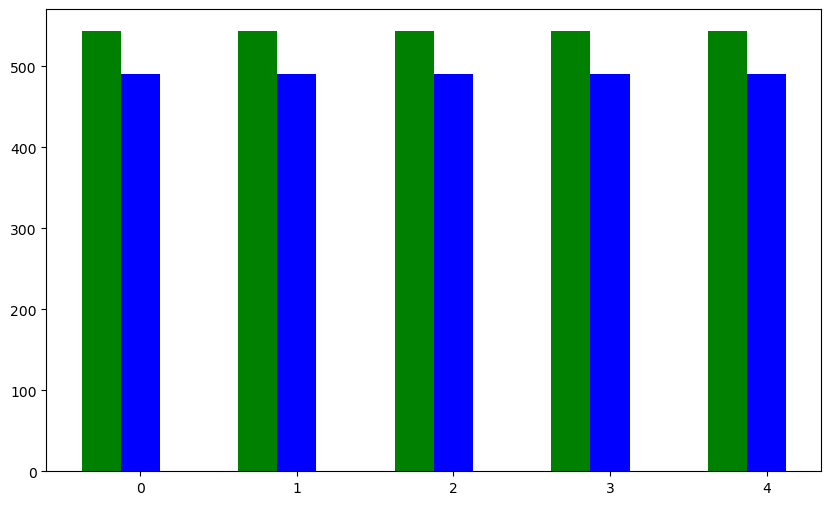

In [44]:
winter_months = [11, 12, 1, 2, 3]
month_labels = ['Nov','Dec','Jan','Feb','Mar']


x = np.arange(len(winter_months))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

for month in winter_months:
    ax.bar(x - width, filtered_seasonal_rain_sum_at_site_era5_4km.sel(month=month), width, color='green', label='ERA5 4km')
    ax.bar(x,         filtered_seasonal_rain_sum_at_site_era5_regridded_31km.sel(month=month), width, color='blue',  label='ERA5 31km'  )
    ax.bar(x + width, monthly_sum_ASOS[month], width, color='black', label='Station Data PABE')


ax.set_xticks(x)
ax.set_xticklabels(month_labels)
ax.set_ylabel('Total Monthly Precipitation (mm)')
ax.set_title('Winter Monthly Precipitation Totals')
ax.legend()

plt.tight_layout()
plt.show()
